(example-mzi)=
# Mach-Zehnder interferometer

In this tutorial, we'll define and simulate a simple circuit known as a
Mach-Zender Interferometer (MZI). This tutorial will walk through the code
found in ``examples/mzi.py`` of the Simphony repository. We expect you to have
read the previous tutorial, [intro](./intro).

As an added bonus, we'll use
[JAX](https://jax.readthedocs.io/en/latest/index.html), which can provide a
nice speedup for larger circuits if their models are appropriately defined and
you have a GPU.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

## Deconstructing the MZI

In an MZI, light entering the circuit is split and travels down two paths of
differing lengths. When the light is recombined, it interferes, and the output
is frequency-dependent.

```{figure} /_static/images/mzi.png
:alt: waveguide
:align: center

A basic MZI. 
```

The MZI we'll create can be broken down into constituent parts. Simphony
includes models for these constituent parts below:

```{figure} /_static/images/mzi_outline_ports_marked.png
:alt: mzi
:align: center

Reusable components in an MZI.
```

The grating couplers are the input and output for light in the circuit. The
Y-branch can split and recombine light, and because the waveguides which carry
light across the circuit are different lengths, this produces interference when
the light is recombined at the second Y-branch. We can now begin defining our
circuit in Simphony using the components we have identified.


## Defining the circuit

First we need to import the necessary Simphony modules. The ``siepic`` model
library, the ``SweepSimulator`` and the ``MonteCarloSweepSimulator`` will be
all that we need. We will also import ``matplotlib.pyplot``, from outside of
Simphony, to view the results of our simulation.

In [2]:
from simphony.libraries import siepic
from simphony.circuit import Circuit

We then create all the components identified earlier. These include the grating
couplers, the Y-branches, and the waveguides (which can be defined at any
arbitrary length, on the condition that the two lengths are different).

In [3]:
gc_input = siepic.GratingCoupler()
y_splitter = siepic.YBranch()
wg_long = siepic.Waveguide(length=150)
wg_short = siepic.Waveguide(length=50)
y_recombiner = siepic.YBranch()
gc_output = siepic.GratingCoupler()

Once we have our components, we can connect them. We can reference the diagram above on which connections to make.

Connections can be defined in the following ways:

* port to port (connect two explicit ports)
* port to model (connect an explicit port to the next available port on a model)
* model to port (connect the next available port on a model to an explicit port)
* model to model (iterate over the next available ports on a model to the next available ports on another model)
* model to list of ports (sequentially connect the next available port on a model to a list of explicit ports)
* model to list of models (sequentially connect the next available port on a model to the first available port from each model in a list)

In [4]:
# Next we connect the components to each other in a circuit
ckt = Circuit()

# Here we connect two explicit ports directly. Ports can be addressed by their
# index or their name. If you don't specify a port, it will automatically
# return the next available port.
ckt.connect(gc_input.o(0), y_splitter.o(0))

# Or, you can connect a model to a list of ports. It will iterate through
# unconnected ports of the first argument in their definition order based on 
# the model and pair them with the ports in the list (or, if they are also 
# models, the first unconnected port of each model in the list).
ckt.connect(y_splitter, [wg_short, wg_long])

# Calling ``.o()`` without an argument returns the next available optical port,
# or ``None`` if there are no more ports available.
ckt.connect(gc_output.o(), y_recombiner)

# Finish making connections
ckt.connect(y_recombiner, [wg_short, wg_long])

```{note}
There are several different ways of connecting components
in Simphony, and many are demonstrated in this example,
with comments included.

You may also wish to rename pins for better semantics when
writing your own circuit. This can be done with
``component.rename_pins("new_pin1", "new_pin2", ...)``, on
any of the components we have created.

``rename_pins`` can be called on a model itself. This will
create default names for any new component you instantiate
of that model.
```

To help with debugging, there's a convenient little function that shows all components, their ports, and their connection status. Just like on switches, ``|`` means connected, and ``O`` means open or available.

In [5]:
print(ckt.port_info())

"circuit0" contains 6 models:
<GratingCoupler at 0x7f0b917d87d0 (o: [+o0, o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b6468ebd0>
  O <OPort "o1" at 0x7f0b6468d150>
<YBranch at 0x7f0b650bb110 (o: [+o0, +o1, +o2], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b6468d190>
  | <OPort "o1" (connected) at 0x7f0b6468db10>
  | <OPort "o2" (connected) at 0x7f0b6468d110>
<Waveguide at 0x7f0b650bbe50 (o: [+o0, +o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b6467f450>
  | <OPort "o1" (connected) at 0x7f0b6473b6d0>
<Waveguide at 0x7f0b6468d0d0 (o: [+o0, +o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b8f5fc2d0>
  | <OPort "o1" (connected) at 0x7f0bf1e6f590>
<GratingCoupler at 0x7f0b647384d0 (o: [+o0, o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b6473be10>
  O <OPort "o1" at 0x7f0b6473b310>
<YBranch at 0x7f0b64738a90 (o: [+o0, +o1, +o2], e: [None])>:
  | <OPort "o0" (connected) at 0x7f0b64738910>
  | <OPort "o1" (connected) at 0x7f0b64739050>
  | <OPort "o2" (conn

We can even visualize the connections using NetworkX:

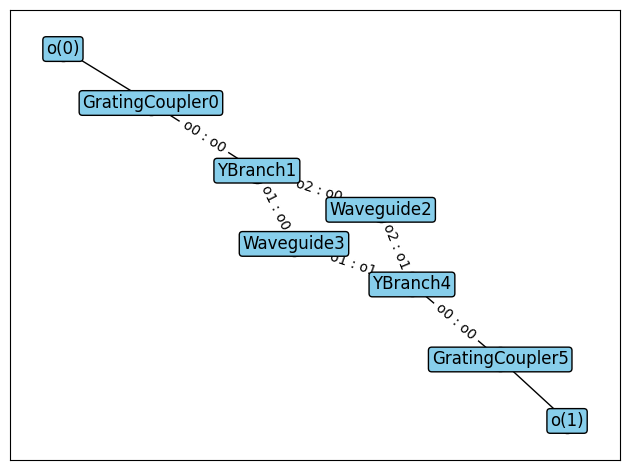

In [6]:
ckt.plot_networkx()
plt.show()

These are all the connections required to define our circuit. The next step will be to run the simulations.

## Sweep simulation

First, we'll do a standard sweep simulation. We define the simulator, the wavelength range to run, and then add an ideal laser to 
the input and ideal photodetectors to the output of our circuit. Note that simphony uses microns as the standard wavelength unit.

In [7]:
from simphony.simulation import ClassicalSim
# import jax.numpy as jnp

wl = np.linspace(1.5, 1.6, 1000)

sim = ClassicalSim(ckt=ckt, wl=wl)
laser = sim.add_laser(ports=ckt.o(0), power=1.0)
detector = sim.add_detector(ports=ckt.o(1))

Now we simulate.

In [8]:
result = sim.run()

AttributeError: module 'jax.numpy' has no attribute 'complex'

The list of detectors in the simulation result have some handy functions for plotting the data. Or, you can access the data directly from its ``.wl`` and ``.power`` attributes.

In [9]:
result.detectors[0].plot()

NameError: name 'result' is not defined

You can also access the underlying data directly. Here we use [``matplotlib``](https://matplotlib.org/) to plot the magnitude squared of scattering parameters of the MZI.

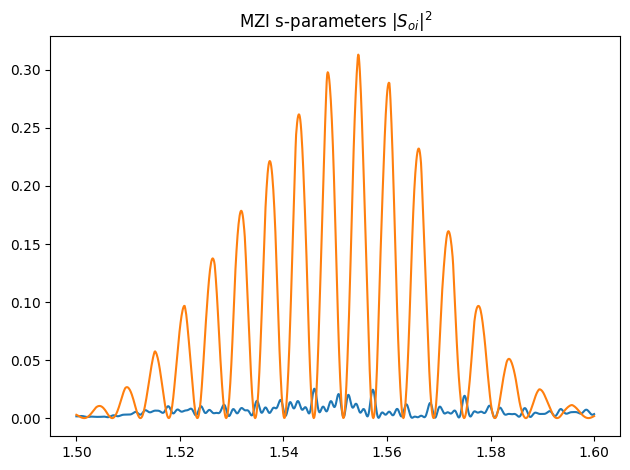

In [10]:
wl = result.wl
s = result.s_params

plt.plot(wl, np.abs(s[:,0])**2)
plt.title(r"MZI s-parameters $|S_{oi}|^2$")
plt.tight_layout()
plt.show()